In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import logging


import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en')

#nltk.download('punkt')
#nltk.download('stopwords')
#from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from autocorrect import spell
    
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix    

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression




## labels
0 - work

1 - industry 

2 - politic

3 - life and family

4 - charity

5 - flaunt wealth

6 - sport event or hobbies

7 - public activity

8 - personal development of the CEO

9 - current events and social issues

10 - others

<br/><br/>
## reference
### - basic concept : 
https://www.linkedin.com/pulse/text-classification-using-bag-words-approach-nltk-scikit-rajendran/

this post should split data earlier

### - model selection: 
https://realpython.com/python-keras-text-classification/

### - the post is mainly followed: 
https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

### - its imbalance version: 
https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

### - imbalanced data processing using tweet as example
https://towardsdatascience.com/yet-another-twitter-sentiment-analysis-part-1-tackling-class-imbalance-4d7a7f717d44

### -imbalanced data with kera
https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1

<br/><br/>
## import data

In [203]:
#prestore it as txt to make inread data prettier
#change sub label to sub_label
dataset = pd.read_csv(r'tweet label2.txt',  engine = "python", index_col=False, skiprows = 0, 
        encoding ="ISO-8859-1", na_values = '-', delimiter =',', skipinitialspace=True, quotechar='"')
    
dataset.head()

,status_id,label,sub_label,fulltext
0,'935610534489219072,0,NaN,"Our #1 best seller, Japanese Cherry Blossom, sells 30.2 million products each year!"
1,'935613720650309632,0,NaN,"I got my start in 1963, when I used a $5,000 loan from my aunt to open The Limited."
2,'967109017502851072,6,NaN,Can?? blame a guy for trying #respect @StephenCurry30 https://t.co/gAlWIDVwQJ
3,'1011457609180667909,6,NaN,Love @TeamLou23 He really earned the sixth man of the year. All @LAClippers fans show him some appreciation!!! Thanks Lou
4,'928115711943348224,6,NaN,Want to know what commitment and determination look like? Great @SInow piece on @blakegriffin32 https://t.co/GV7NNHhffT #ItTakesEverything


In [204]:
#clean wired data cause by csv 
#delete if label is not number or not null
dataset['problem_l'] = ~dataset.label.astype(str).apply(lambda x: x.isnumeric())
dataset['problem_s'] = ~dataset.label.isnull() 
dataset['problem_sub_l'] = ~dataset.sub_label.astype(str).apply(lambda x: x.isnumeric())
dataset['problem_sub_s'] = ~dataset.sub_label.isnull() 
dataset = dataset.drop(dataset[((dataset.problem_l) & (dataset.problem_s)) | ((dataset.problem_sub_l) & (dataset.problem_sub_s)) ].index)

In [205]:
dataset.label.value_counts()

7     605
0     589
1     583
9     236
10    125
6     106
2     100
4     62 
3     57 
8     26 
Name: label, dtype: int64

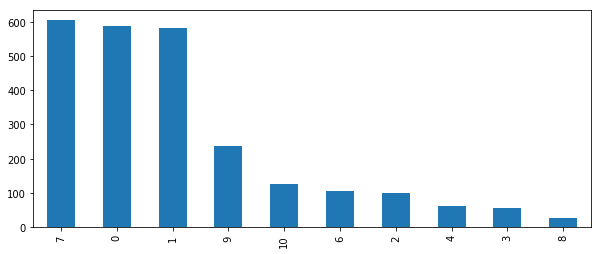

In [206]:
plt.figure(figsize=(10,4))
dataset.label.value_counts().plot(kind='bar');

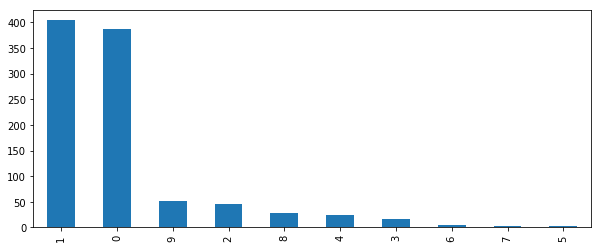

In [207]:
plt.figure(figsize=(10,4))
dataset.sub_label.value_counts().plot(kind='bar');

In [208]:
print('row :', dataset.shape[0])
print('words :', dataset['fulltext'].astype(str).apply(lambda x: len(x.split(' '))).sum())
dataset.info()

row : 186769
words : 3192313
<class 'pandas.core.frame.DataFrame'>
Int64Index: 186769 entries, 0 to 187276
Data columns (total 8 columns):
status_id        186706 non-null object
label            2489 non-null object
sub_label        966 non-null object
fulltext         186688 non-null object
problem_l        186769 non-null bool
problem_s        186769 non-null bool
problem_sub_l    186769 non-null bool
problem_sub_s    186769 non-null bool
dtypes: bool(4), object(4)
memory usage: 7.8+ MB


In [209]:
text = dataset[['status_id', 'fulltext', 'label', 'sub_label']]
text = text[text['status_id'].notnull()]
text.head()

,status_id,fulltext,label,sub_label
0,'935610534489219072,"Our #1 best seller, Japanese Cherry Blossom, sells 30.2 million products each year!",0,NaN
1,'935613720650309632,"I got my start in 1963, when I used a $5,000 loan from my aunt to open The Limited.",0,NaN
2,'967109017502851072,Can?? blame a guy for trying #respect @StephenCurry30 https://t.co/gAlWIDVwQJ,6,NaN
3,'1011457609180667909,Love @TeamLou23 He really earned the sixth man of the year. All @LAClippers fans show him some appreciation!!! Thanks Lou,6,NaN
4,'928115711943348224,Want to know what commitment and determination look like? Great @SInow piece on @blakegriffin32 https://t.co/GV7NNHhffT #ItTakesEverything,6,NaN


In [16]:
# text_type = text.astype({"status_id":'str', "fulltext":'str', "label":'float', "sub_label":'float'})
# text_type.info()

## clean the input

In [210]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [211]:
STOPWORDS = set(stopwords.words('english'))

def spacy_cleaner(text):
    #lower case
    text = text.lower()
    #unicode_escape for extra "\" before unicode character, then unidecode
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    #there are apostrophe and singlequote people use for contraction. any apostrophe) is changed to single quote
    apostrophe_handled = re.sub("’", "'", decoded)
    #Contraction check
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        #Filtering punctuation, white space, numbers, URL using Spacy methods while keeping the text content of hashtag intact
        #Removed @mention
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):            
            pass
        else:
            #Pronouns are kept as they are since Spacy lemmatizer transforms every pronoun to "-PRON-"
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                #Lemmatize: lemmatized each token using Spacy method '.lemma_'.
                #Special character removal
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                #Single syllable token removal
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    """joined = ' '.join(PorterStemmer().stem(spell(word)) for word in final_tokens if word not in STOPWORDS) """ 
    # delete stopwors from text,  finding the base word, auto correct
    joined = ' '.join(final_tokens)
    #it is a simple spell correction, if the same character is repeated more than two times, it shortens the repetition to two
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected


text['cleantext'] = text['fulltext'].astype(str).apply(spacy_cleaner)

c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: invalid escape sequence '\s'
  
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: invalid escape sequence '\c'
  
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: invalid escape sequence '\ '
  
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: invalid escape sequence '\d'
  
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: invalid escape sequence '\e'
  
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: invalid escape sequence '\('
  
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: Deprecati

In [212]:
pd.set_option('display.max_colwidth', -1)
#
print(text['cleantext'].apply(lambda x: len(x.split(' '))).sum())
text['cleantext'].head() 

2734623


0    our good seller japanese cherry blossom sell product each year                            
1    get my start in when use loan from my aunt to open the limited                            
2    can blame guy for try respect                                                             
3    love he really earn the sixth man of the year all fan show him some appreciation thank lou
4    want to know what commitment and determination look like great piece on ittakeseverything 
Name: cleantext, dtype: object

In [213]:
df = text[text['label'].notnull()]
print(df.head())
df.info()

              status_id  \
0  '935610534489219072    
1  '935613720650309632    
2  '967109017502851072    
3  '1011457609180667909   
4  '928115711943348224    

                                                                                                                                     fulltext  \
0  Our #1 best seller, Japanese Cherry Blossom, sells 30.2 million products each year!                                                          
1  I  got my start in 1963, when I  used a $5,000 loan from my aunt to open The Limited.                                                        
2  Can?? blame a guy for trying #respect @StephenCurry30 https://t.co/gAlWIDVwQJ                                                                
3  Love @TeamLou23 He really earned the sixth man of the year. All @LAClippers fans show him some appreciation!!!  Thanks Lou                   
4  Want to know what commitment and determination look like? Great @SInow piece on @blakegriffin32 https://t.co/

In [214]:
## unlabeled data that need to be predicted
df_test = text[text['label'].isnull()]
print(df_test.head())
df_test.info()

                 status_id  \
901   '1121480618867666950   
1356  '704360252368506880    
1367  '279689055862669312    
1775  '695432140700282886    
2387  '1078292356636397569   

                                                                                                                                                                 fulltext  \
901   Blast from the past!?\n?\nOver 30 years ago to be exact!\n?\nI guess I had not learned how to use lower case letters at that point ?????????https://t.co/JPXo6TuN4M   
1356  Student-centered learning yields better education outcomes https://t.co/e2fHOBk7vo                                                                                    
1367  From our great customer event at Dell World this week at Darrell K Royal ??Texas Memorial Stadium http://t.co/jqb6vsob                                                
1775  See you at https://t.co/OXdGxkRlVE! :) https://t.co/YsADlWDkF5                                                           

## try ordinary approach on imbalanced data 
<br/><br/>
### result explaination
#### - Accuracy
Classification accuracy is our starting point. It is the number of correct predictions made divided by the total number of predictions made, multiplied by 100 to turn it into a percentage.

#### -Precision
Precision is the number of True Positives divided by the number of True Positives and False Positives. Put another way, it is the number of positive predictions divided by the total number of positive class values predicted. It is also called the Positive Predictive Value (PPV).
Precision can be thought of as a measure of a classifiers exactness. A low precision can also indicate a large number of False Positives.

#### - Recall
Recall is the number of True Positives divided by the number of True Positives and the number of False Negatives. Put another way it is the number of positive predictions divided by the number of positive class values in the test data. It is also called Sensitivity or the True Positive Rate.
Recall can be thought of as a measure of a classifiers completeness. A low recall indicates many False Negatives.

#### - F1 score
F1 = 2 * (precision * recall) / (precision + recall)
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal.
In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the average parameter.

#### Sourxe
https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

<br/><br/>

### sklearn.feature_extraction.text.TfidfVectorizer 
#### parameter
- sublinear_df is set to True to use a logarithmic form for frequency.
- min_df is the minimum numbers of documents a word must be present in to be kept.
- norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1.

norm：一般譯成範數

(norm 有規範的意思，也就是加上規範使其正常化)，建議把 Norm 想成長度就好 (事實上norm是長度的抽象推廣)

https://ch-hsieh.blogspot.com/2010/04/norm.html

- ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams.

n-gram is basically set of occurring words within given window 

https://stackoverflow.com/questions/43463792/what-is-the-difference-between-bigram-and-unigram-text-features-extract
- stop_words can be set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features.

<br/><br/>


### parameter for precision_score
- 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html


In [215]:
# setting variable for n fold and average method
split = 5
avg_method = 'macro'

In [216]:
#def result printintg function
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])

        print('accuracy %s' % accuracy_score(prediction, Y[test]))
        print(classification_report(Y[test], prediction))

        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))

In [217]:
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()

In [218]:
# use original data
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])

lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), original_pipeline, avg_method)


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.4760956175298805


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.56      0.67      0.61       118
           1       0.42      0.51      0.46       117
          10       0.67      0.16      0.26        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        12
           4       1.00      0.15      0.27        13
           6       0.00      0.00      0.00        22
           7       0.45      0.77      0.57       121
           8       0.00      0.00      0.00         6
           9       1.00      0.02      0.04        48

    accuracy                           0.48       502
   macro avg       0.41      0.23      0.22       502
weighted avg       0.49      0.48      0.41       502



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.47695390781563124


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.56      0.62      0.59       118
           1       0.42      0.53      0.47       117
          10       1.00      0.04      0.08        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        12
           4       1.00      0.23      0.38        13
           6       0.00      0.00      0.00        21
           7       0.46      0.82      0.59       121
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        47

    accuracy                           0.48       499
   macro avg       0.34      0.22      0.21       499
weighted avg       0.42      0.48      0.40       499



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.45875251509054327


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.55      0.59      0.57       118
           1       0.38      0.46      0.42       117
          10       0.17      0.04      0.06        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        11
           4       0.50      0.08      0.14        12
           6       0.00      0.00      0.00        21
           7       0.46      0.84      0.60       121
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        47

    accuracy                           0.46       497
   macro avg       0.21      0.20      0.18       497
weighted avg       0.35      0.46      0.39       497



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.4596774193548387


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.55      0.65      0.60       118
           1       0.44      0.47      0.45       116
          10       0.33      0.08      0.13        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        11
           4       1.00      0.17      0.29        12
           6       0.00      0.00      0.00        21
           7       0.41      0.76      0.54       121
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        47

    accuracy                           0.46       496
   macro avg       0.27      0.21      0.20       496
weighted avg       0.38      0.46      0.39       496



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.46464646464646464


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.50      0.66      0.57       117
           1       0.47      0.52      0.49       116
          10       1.00      0.08      0.15        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        11
           4       1.00      0.08      0.15        12
           6       0.00      0.00      0.00        21
           7       0.43      0.74      0.54       121
           8       0.00      0.00      0.00         5
           9       1.00      0.02      0.04        47

    accuracy                           0.46       495
   macro avg       0.44      0.21      0.19       495
weighted avg       0.50      0.46      0.40       495



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------
accuracy: 46.72% (+/- 0.79%)
precision: 33.43% (+/- 8.58%)
recall: 21.55% (+/- 0.96%)
f1 score: 20.07% (+/- 1.38%)


## split test & train data

In [224]:
X = df.cleantext
y = df.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 1)
#random_state is equal to set seed


## dataset need prediction

In [220]:
X_train2 = df.cleantext
y_train2 =  df.label
X_test2 = df_test.cleantext

## RandomOverSampler¶

##  train  Multinomial Naive Bayes 
as a simple baseline
<br/><br/>
### reference 
#### -why is pipeline essential &rarr; 
to keep train and test data fit correctly during cross validation 

https://towardsdatascience.com/a-simple-example-of-pipeline-in-machine-learning-with-scikit-learn-e726ffbb6976 

#### -what is CountVectorizer &rarr; 
An encoded vector is returned with a length of the entire vocabulary and an integer count for the number of times each word appeared in the document.
#### -what is TfidfTransformer &rarr; 
“Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.Term Frequency summarizes how often a given word appears within a document. Inverse Document Frequency downscales words that appear a lot across documents.

https://machinelearningmastery.com/prepare-text-data-machine-learning-scikit-learn/
#### -what is  Multinomial Naive Bayes classifier &rarr; 
a specific instance of a Naive Bayes classifier which uses a multinomial distribution for each of the features

https://stats.stackexchange.com/questions/33185/difference-between-naive-bayes-multinomial-naive-bayes

Multinomial Distribution 

https://www.tutorialspoint.com/statistics/multinomial_distribution.htm

In [225]:
#vectorizer => transformer => classifier
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), nb, avg_method)

#nb.fit(X_train, y_train)

accuracy 0.4641434262948207


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.56      0.66      0.60       118
           1       0.47      0.44      0.46       117
          10       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        12
           4       1.00      0.15      0.27        13
           6       0.00      0.00      0.00        22
           7       0.40      0.83      0.54       121
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        48

    accuracy                           0.46       502
   macro avg       0.24      0.21      0.19       502
weighted avg       0.36      0.46      0.39       502



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------
accuracy 0.46893787575150303


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.57      0.62      0.59       118
           1       0.49      0.48      0.48       117
          10       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        12
           4       1.00      0.23      0.38        13
           6       0.00      0.00      0.00        21
           7       0.40      0.84      0.55       121
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        47

    accuracy                           0.47       499
   macro avg       0.25      0.22      0.20       499
weighted avg       0.37      0.47      0.40       499



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------
accuracy 0.4426559356136821


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.54      0.60      0.57       118
           1       0.43      0.37      0.40       117
          10       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        11
           4       0.50      0.08      0.14        12
           6       0.00      0.00      0.00        21
           7       0.40      0.87      0.55       121
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        47

    accuracy                           0.44       497
   macro avg       0.19      0.19      0.17       497
weighted avg       0.34      0.44      0.36       497



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------
accuracy 0.48185483870967744


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.58      0.65      0.61       118
           1       0.52      0.45      0.48       116
          10       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        11
           4       1.00      0.17      0.29        12
           6       0.00      0.00      0.00        21
           7       0.41      0.89      0.57       121
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        47

    accuracy                           0.48       496
   macro avg       0.25      0.22      0.19       496
weighted avg       0.38      0.48      0.40       496



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------
accuracy 0.4686868686868687


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.54      0.70      0.61       117
           1       0.49      0.42      0.46       116
          10       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        20
           3       0.00      0.00      0.00        11
           4       1.00      0.08      0.15        12
           6       0.00      0.00      0.00        21
           7       0.41      0.83      0.55       121
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        47

    accuracy                           0.47       495
   macro avg       0.24      0.20      0.18       495
weighted avg       0.37      0.47      0.39       495



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------
accuracy: 46.53% (+/- 1.28%)
precision: 23.45% (+/- 2.39%)
recall: 20.76% (+/- 0.92%)
f1 score: 18.48% (+/- 1.23%)


In [200]:
# %%time
# y_pred = nb.predict(X_test)

# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred))

accuracy 0.4538152610441767


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.59      0.63      0.61       185
           1       0.50      0.39      0.44       188
          10       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        27
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        17
           6       0.00      0.00      0.00        32
           7       0.37      0.85      0.51       174
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00        64

    accuracy                           0.45       747
   macro avg       0.15      0.19      0.16       747
weighted avg       0.36      0.45      0.38       747

Wall time: 53 ms


## try to predict unlabeled


In [221]:
nb.fit(X_train2, y_train2)
df_test['y_pred'] = nb.predict(X_test2)


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [223]:
df_test.head()

,status_id,fulltext,label,sub_label,cleantext,y_pred
901,'1121480618867666950,Blast from the past!?\n?\nOver 30 years ago to be exact!\n?\nI guess I had not learned how to use lower case letters at that point ?????????https://t.co/JPXo6TuN4M,NaN,NaN,blast from the past over year ago to be exact guess have not learn how to use low case letter at that point,0
1356,'704360252368506880,Student-centered learning yields better education outcomes https://t.co/e2fHOBk7vo,NaN,NaN,student center learning yield well education outcome,1
1367,'279689055862669312,From our great customer event at Dell World this week at Darrell K Royal ??Texas Memorial Stadium http://t.co/jqb6vsob,NaN,NaN,from our great customer event at dell world this week at darrell royal texas memorial stadium,7
1775,'695432140700282886,See you at https://t.co/OXdGxkRlVE! :) https://t.co/YsADlWDkF5,NaN,NaN,see you at,7
2387,'1078292356636397569,??,NaN,NaN,,7


## Linear Support Vector Machine 
widely regarded as one of the best text classification algorithms

## note :
SGDClassifier is not a classifier but a linear classifier optimized by the SGD. It implements by regularising linear models with Stochastic Gradient Descent.

clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42) it is an implementation of Linear SVM. loss="hinge": (soft-margin) linear Support Vector Machine.

clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42) . It is an implementation of Logisitic regression.
## reference:
### -How to make SGD Classifier perform as well as Logistic Regression using parfit
https://towardsdatascience.com/how-to-make-sgd-classifier-perform-as-well-as-logistic-regression-using-parfit-cc10bca2d3c4

In [226]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), sgd, avg_method)

# sgd.fit(X_train, y_train)

accuracy 0.5159362549800797


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.55      0.70      0.61       118
           1       0.46      0.39      0.42       117
          10       0.39      0.28      0.33        25
           2       0.45      0.25      0.32        20
           3       0.33      0.08      0.13        12
           4       0.80      0.62      0.70        13
           6       0.58      0.32      0.41        22
           7       0.53      0.73      0.61       121
           8       0.00      0.00      0.00         6
           9       0.48      0.29      0.36        48

    accuracy                           0.52       502
   macro avg       0.46      0.37      0.39       502
weighted avg       0.50      0.52      0.49       502



c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


--------------------------------------------------
accuracy 0.5250501002004008
              precision    recall  f1-score   support

           0       0.55      0.64      0.59       118
           1       0.50      0.50      0.50       117
          10       0.33      0.12      0.18        25
           2       0.78      0.35      0.48        20
           3       0.00      0.00      0.00        12
           4       0.55      0.46      0.50        13
           6       0.44      0.19      0.27        21
           7       0.53      0.74      0.62       121
           8       0.67      0.40      0.50         5
           9       0.52      0.36      0.43        47

    accuracy                           0.53       499
   macro avg       0.49      0.38      0.41       499
weighted avg       0.51      0.53      0.50       499

--------------------------------------------------
accuracy 0.5171026156941649
              precision    recall  f1-score   support

           0       0.54     

In [167]:
# %%time
# # 
# y_pred = sgd.predict(X_test)

# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred))

## Logistic Regression

In [227]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), logreg, avg_method)

#logreg.fit(X_train, y_train)

c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.4243027888446215
              precision    recall  f1-score   support

           0       0.45      0.52      0.48       118
           1       0.35      0.44      0.39       117
          10       0.21      0.24      0.22        25
           2       0.42      0.25      0.31        20
           3       0.40      0.17      0.24        12
           4       0.67      0.46      0.55        13
           6       0.60      0.27      0.37        22
           7       0.50      0.51      0.51       121
           8       1.00      0.17      0.29         6
           9       0.44      0.25      0.32        48

    accuracy                           0.42       502
   macro avg       0.50      0.33      0.37       502
weighted avg       0.44      0.42      0.42       502

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.45490981963927857
              precision    recall  f1-score   support

           0       0.49      0.53      0.51       118
           1       0.41      0.44      0.43       117
          10       0.25      0.20      0.22        25
           2       0.50      0.30      0.37        20
           3       0.00      0.00      0.00        12
           4       1.00      0.38      0.56        13
           6       0.33      0.33      0.33        21
           7       0.54      0.60      0.56       121
           8       1.00      0.40      0.57         5
           9       0.32      0.34      0.33        47

    accuracy                           0.45       499
   macro avg       0.48      0.35      0.39       499
weighted avg       0.46      0.45      0.45       499

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.43259557344064387
              precision    recall  f1-score   support

           0       0.50      0.49      0.50       118
           1       0.36      0.46      0.41       117
          10       0.12      0.12      0.12        25
           2       0.36      0.20      0.26        20
           3       0.17      0.09      0.12        11
           4       0.88      0.58      0.70        12
           6       0.38      0.38      0.38        21
           7       0.51      0.55      0.53       121
           8       1.00      0.20      0.33         5
           9       0.41      0.26      0.32        47

    accuracy                           0.43       497
   macro avg       0.47      0.33      0.37       497
weighted avg       0.44      0.43      0.43       497

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.42943548387096775
              precision    recall  f1-score   support

           0       0.49      0.51      0.50       118
           1       0.32      0.33      0.33       116
          10       0.29      0.32      0.30        25
           2       0.46      0.30      0.36        20
           3       0.40      0.18      0.25        11
           4       0.56      0.42      0.48        12
           6       0.56      0.43      0.49        21
           7       0.46      0.60      0.52       121
           8       0.33      0.20      0.25         5
           9       0.48      0.26      0.33        47

    accuracy                           0.43       496
   macro avg       0.43      0.35      0.38       496
weighted avg       0.43      0.43      0.42       496

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.4222222222222222
              precision    recall  f1-score   support

           0       0.49      0.62      0.55       117
           1       0.38      0.41      0.39       116
          10       0.24      0.32      0.28        25
           2       0.43      0.15      0.22        20
           3       0.30      0.27      0.29        11
           4       0.50      0.17      0.25        12
           6       0.33      0.19      0.24        21
           7       0.43      0.46      0.45       121
           8       1.00      0.40      0.57         5
           9       0.42      0.23      0.30        47

    accuracy                           0.42       495
   macro avg       0.45      0.32      0.35       495
weighted avg       0.42      0.42      0.41       495

--------------------------------------------------
accuracy: 43.27% (+/- 1.17%)
precision: 46.91% (+/- 2.37%)
recall: 33.80% (+/- 1.26%)
f1 score: 37.13% (+/- 1.22%)


In [164]:
# %%time

# y_pred = logreg.predict(X_test)

# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred))

accuracy 0.4578313253012048
              precision    recall  f1-score   support

           0       0.52      0.57      0.54       185
           1       0.44      0.49      0.46       188
          10       0.23      0.31      0.26        32
           2       0.38      0.22      0.28        27
           3       0.20      0.05      0.08        20
           4       0.67      0.35      0.46        17
           6       0.45      0.31      0.37        32
           7       0.49      0.54      0.51       174
           8       1.00      0.12      0.22         8
           9       0.37      0.27      0.31        64

    accuracy                           0.46       747
   macro avg       0.47      0.32      0.35       747
weighted avg       0.46      0.46      0.45       747

Wall time: 58 ms


## Word2vec and Logistic Regression

### note:
Word2vec is a type of mapping that allows words with similar meaning to have similar vector representation &rarr;

use surrounding words to represent the target words with a Neural Network whose hidden layer encodes the word representation.

In [228]:
%%time
import gensim
from gensim.models import Word2Vec

wv = gensim.models.KeyedVectors.load_word2vec_format("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", binary=True)
wv.init_sims(replace=True)

Wall time: 7min 23s


In [229]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

## Bag of word averaging
https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

In [230]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [231]:

train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['cleantext']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['cleantext']), axis=1).values


In [232]:
X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0norm` (Attribute will be removed in 4.0.0, use self.vectors_norm instead).
  
W0812 01:16:17.230739 15920 <ipython-input-230-63760c81b177>:12] cannot compute similarity with no input []
W0812 01:16:17.636733 15920 <ipython-input-230-63760c81b177>:12] cannot compute similarity with no input ['getmodern']
W0812 01:16:17.721738 15920 <ipython-input-230-63760c81b177>:12] cannot compute similarity with no input []
W0812 01:16:18.054777 15920 <ipython-input-230-63760c81b177>:12] cannot compute similarity with no input []


## logistic regression classifiers performs on these word-averaging document features

In [233]:
logreg = LogisticRegression(n_jobs=1, C=1e5)

#can't work
# lr_cv(split, X_train_word_average, X_test_word_average, logreg, avg_method)

logreg = logreg.fit(X_train_word_average, train['label'])
y_pred = logreg.predict(X_test_word_average)

c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [236]:

print('accuracy %s' % accuracy_score(y_pred, test.label))
print(classification_report(test.label, y_pred))

accuracy 0.42971887550200805
              precision    recall  f1-score   support

           0       0.51      0.47      0.49       192
           1       0.42      0.34      0.38       202
          10       0.13      0.27      0.18        26
           2       0.39      0.41      0.40        27
           3       0.11      0.18      0.13        11
           4       0.67      0.30      0.41        20
           6       0.46      0.46      0.46        28
           7       0.49      0.60      0.54       164
           8       0.33      0.25      0.29         8
           9       0.36      0.30      0.33        69

    accuracy                           0.43       747
   macro avg       0.39      0.36      0.36       747
weighted avg       0.45      0.43      0.43       747



## Doc2vec and Logistic Regression¶

## reference:
### -what is Doc2vec
https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e

In [145]:
from gensim.models import Doc2Vec
from sklearn import utils
from gensim.models.doc2vec import TaggedDocument
from tqdm import tqdm

tqdm.pandas(desc="progress-bar")


In [146]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
    We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
    a dummy index of the post.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(TaggedDocument(v.split(), [label]))
    return labeled

In [149]:
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [150]:
all_data[:2]


[TaggedDocument(words=['love', 'see', 'how', 'our', 'tech', 'help', 'customer', 'like', 'the', 'boston', 'aim', 'for', 'the', 'fence'], tags=['Train_0']),
 TaggedDocument(words=['meet', 'the', 'inspiron', 'series', 'in', 'special', 'edition'], tags=['Train_1'])]

In [151]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "
100%|█████████████████████████████████████████████████████████████████████████| 2489/2489 [00:00<00:00, 1242812.22it/s]


In [152]:

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████████████████████████████████████████████████████████████████████| 2489/2489 [00:00<00:00, 828541.48it/s]
W0811 23:05:24.536418 15920 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|██████████████████████████████████████████████████████████████████████████| 2489/2489 [00:00<00:00, 497432.82it/s]
W0811 23:05:45.475617 15920 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|██████████████████████████████████████████████████████████████████████████| 2489/2489 [00:00<00:00, 830717.17it/s]
W0811 23:06:06.144796 15920 base_any2vec.py:1386] under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
100%|█████████████████████████████████████████████████████████████████████████| 2489/2489 [00:00<00:00, 2495129.70it/s]
W0811 23:06:25.971814 15920 base_any2vec.py:1386] under 10 jobs per worker: consider setting a

In [153]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [157]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

logreg = LogisticRegression(n_jobs=1, C=1e5)

#
logreg.fit(train_vectors_dbow, y_train)

logreg = logreg.fit(train_vectors_dbow, y_train)
y_pred = logreg.predict(test_vectors_dbow)

c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", Futur

In [159]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.3855421686746988
              precision    recall  f1-score   support

           0       0.56      0.49      0.52       185
           1       0.42      0.36      0.38       188
          10       0.08      0.16      0.11        32
           2       0.29      0.37      0.33        27
           3       0.17      0.25      0.20        20
           4       0.12      0.24      0.16        17
           6       0.17      0.25      0.20        32
           7       0.52      0.49      0.51       174
           8       0.14      0.25      0.18         8
           9       0.26      0.19      0.22        64

    accuracy                           0.39       747
   macro avg       0.27      0.30      0.28       747
weighted avg       0.42      0.39      0.40       747



## fixing imbalance with oversampling

In [234]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr)
SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),lr)
ADASYN_pipeline = make_pipeline(tvec, ADASYN(ratio='minority',random_state=777),lr)


### 1. RandomOverSampler¶
Random over-sampling is simply a process of repeating some samples of the minority class and balance the number of samples between classes in the dataset.



In [235]:
lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), ROS_pipeline, avg_method)


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5298804780876494
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       118
           1       0.53      0.42      0.47       117
          10       0.28      0.40      0.33        25
           2       0.33      0.50      0.40        20
           3       0.40      0.33      0.36        12
           4       0.89      0.62      0.73        13
           6       0.67      0.36      0.47        22
           7       0.52      0.69      0.59       121
           8       0.67      0.33      0.44         6
           9       0.46      0.35      0.40        48

    accuracy                           0.53       502
   macro avg       0.54      0.46      0.48       502
weighted avg       0.55      0.53      0.53       502

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5130260521042084
              precision    recall  f1-score   support

           0       0.71      0.58      0.64       118
           1       0.53      0.47      0.50       117
          10       0.23      0.12      0.16        25
           2       0.33      0.50      0.40        20
           3       0.10      0.08      0.09        12
           4       0.56      0.38      0.45        13
           6       0.27      0.19      0.22        21
           7       0.52      0.74      0.61       121
           8       0.67      0.40      0.50         5
           9       0.38      0.36      0.37        47

    accuracy                           0.51       499
   macro avg       0.43      0.38      0.39       499
weighted avg       0.51      0.51      0.50       499

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.4909456740442656
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       118
           1       0.46      0.40      0.43       117
          10       0.09      0.08      0.08        25
           2       0.27      0.35      0.30        20
           3       0.20      0.18      0.19        11
           4       0.56      0.42      0.48        12
           6       0.47      0.43      0.45        21
           7       0.55      0.81      0.65       121
           8       1.00      0.20      0.33         5
           9       0.39      0.23      0.29        47

    accuracy                           0.49       497
   macro avg       0.46      0.36      0.38       497
weighted avg       0.49      0.49      0.48       497

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5201612903225806
              precision    recall  f1-score   support

           0       0.59      0.60      0.60       118
           1       0.55      0.39      0.45       116
          10       0.38      0.48      0.42        25
           2       0.45      0.70      0.55        20
           3       0.25      0.18      0.21        11
           4       0.56      0.42      0.48        12
           6       0.50      0.38      0.43        21
           7       0.50      0.69      0.58       121
           8       0.33      0.20      0.25         5
           9       0.57      0.34      0.43        47

    accuracy                           0.52       496
   macro avg       0.47      0.44      0.44       496
weighted avg       0.53      0.52      0.51       496

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5070707070707071
              precision    recall  f1-score   support

           0       0.55      0.62      0.58       117
           1       0.55      0.48      0.52       116
          10       0.20      0.28      0.23        25
           2       0.41      0.45      0.43        20
           3       0.18      0.18      0.18        11
           4       0.88      0.58      0.70        12
           6       0.43      0.14      0.21        21
           7       0.54      0.69      0.60       121
           8       0.50      0.20      0.29         5
           9       0.45      0.21      0.29        47

    accuracy                           0.51       495
   macro avg       0.47      0.38      0.40       495
weighted avg       0.51      0.51      0.50       495

--------------------------------------------------
accuracy: 51.22% (+/- 1.31%)
precision: 47.36% (+/- 3.67%)
recall: 40.67% (+/- 3.80%)
f1 score: 42.02% (+/- 3.79%)


### 2. SMOTE (Synthetic Minority Over-Sampling Technique
SMOTE is an over-sampling approach in which the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement.
What this means is that when SMOTE creates a new synthetic data, it will choose one data to copy, and look at its k nearest neighbours. Then, on feature space, it will create random values in feature space that is between the original sample and its neighbours.



In [237]:
lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), SMOTE_pipeline, avg_method)


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5318725099601593
              precision    recall  f1-score   support

           0       0.70      0.64      0.67       118
           1       0.55      0.43      0.48       117
          10       0.29      0.44      0.35        25
           2       0.28      0.50      0.36        20
           3       0.33      0.25      0.29        12
           4       1.00      0.54      0.70        13
           6       0.57      0.36      0.44        22
           7       0.54      0.69      0.60       121
           8       0.67      0.33      0.44         6
           9       0.42      0.35      0.39        48

    accuracy                           0.53       502
   macro avg       0.53      0.45      0.47       502
weighted avg       0.55      0.53      0.53       502

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5090180360721442
              precision    recall  f1-score   support

           0       0.65      0.59      0.62       118
           1       0.51      0.45      0.48       117
          10       0.27      0.16      0.20        25
           2       0.29      0.50      0.37        20
           3       0.17      0.08      0.11        12
           4       0.71      0.38      0.50        13
           6       0.28      0.24      0.26        21
           7       0.53      0.72      0.61       121
           8       0.67      0.40      0.50         5
           9       0.40      0.36      0.38        47

    accuracy                           0.51       499
   macro avg       0.45      0.39      0.40       499
weighted avg       0.51      0.51      0.50       499

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.4909456740442656
              precision    recall  f1-score   support

           0       0.61      0.50      0.55       118
           1       0.46      0.41      0.43       117
          10       0.14      0.12      0.13        25
           2       0.28      0.35      0.31        20
           3       0.22      0.18      0.20        11
           4       0.71      0.42      0.53        12
           6       0.48      0.48      0.48        21
           7       0.54      0.79      0.64       121
           8       1.00      0.20      0.33         5
           9       0.38      0.28      0.32        47

    accuracy                           0.49       497
   macro avg       0.48      0.37      0.39       497
weighted avg       0.49      0.49      0.48       497

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5201612903225806
              precision    recall  f1-score   support

           0       0.59      0.60      0.59       118
           1       0.53      0.39      0.45       116
          10       0.30      0.44      0.35        25
           2       0.48      0.70      0.57        20
           3       0.40      0.18      0.25        11
           4       0.56      0.42      0.48        12
           6       0.53      0.38      0.44        21
           7       0.51      0.69      0.59       121
           8       0.33      0.20      0.25         5
           9       0.61      0.36      0.45        47

    accuracy                           0.52       496
   macro avg       0.48      0.44      0.44       496
weighted avg       0.53      0.52      0.51       496

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.5070707070707071
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       117
           1       0.57      0.44      0.50       116
          10       0.26      0.36      0.31        25
           2       0.32      0.45      0.38        20
           3       0.17      0.18      0.17        11
           4       0.88      0.58      0.70        12
           6       0.57      0.19      0.29        21
           7       0.54      0.69      0.61       121
           8       0.33      0.20      0.25         5
           9       0.41      0.26      0.32        47

    accuracy                           0.51       495
   macro avg       0.46      0.40      0.41       495
weighted avg       0.52      0.51      0.50       495

--------------------------------------------------
accuracy: 51.18% (+/- 1.37%)
precision: 48.23% (+/- 2.93%)
recall: 40.98% (+/- 3.04%)
f1 score: 42.41% (+/- 2.93%)


## fixing imbalance with downsampling

In [238]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler

RUS_pipeline = make_pipeline(tvec, RandomUnderSampler(random_state=777),lr)
NM1_pipeline = make_pipeline(tvec, NearMiss(ratio='not minority',random_state=777, version = 1),lr)
NM2_pipeline = make_pipeline(tvec, NearMiss(ratio='not minority',random_state=777, version = 2),lr)
NM3_pipeline = make_pipeline(tvec, NearMiss(ratio='not minority',random_state=777, version = 3, n_neighbors_ver3=4),lr)

### 1. RandomUnderSampler¶
with downsampling, we try to reduce the data of majority class, so that the data classes are balanced.

In [239]:
lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), RUS_pipeline, avg_method)


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.26693227091633465
              precision    recall  f1-score   support

           0       0.54      0.26      0.35       118
           1       0.27      0.09      0.13       117
          10       0.21      0.36      0.26        25
           2       0.23      0.50      0.31        20
           3       0.12      0.58      0.19        12
           4       0.25      0.69      0.37        13
           6       0.17      0.32      0.22        22
           7       0.44      0.25      0.32       121
           8       0.04      0.50      0.08         6
           9       0.38      0.38      0.38        48

    accuracy                           0.27       502
   macro avg       0.26      0.39      0.26       502
weighted avg       0.37      0.27      0.28       502

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.32665330661322645
              precision    recall  f1-score   support

           0       0.59      0.34      0.43       118
           1       0.47      0.26      0.33       117
          10       0.17      0.16      0.17        25
           2       0.17      0.35      0.23        20
           3       0.09      0.25      0.14        12
           4       0.38      0.46      0.41        13
           6       0.16      0.33      0.21        21
           7       0.49      0.42      0.45       121
           8       0.06      0.80      0.12         5
           9       0.26      0.23      0.25        47

    accuracy                           0.33       499
   macro avg       0.28      0.36      0.27       499
weighted avg       0.43      0.33      0.35       499

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.3158953722334004
              precision    recall  f1-score   support

           0       0.67      0.33      0.44       118
           1       0.50      0.23      0.32       117
          10       0.11      0.16      0.13        25
           2       0.21      0.55      0.31        20
           3       0.10      0.45      0.16        11
           4       0.55      0.50      0.52        12
           6       0.23      0.71      0.34        21
           7       0.48      0.34      0.40       121
           8       0.06      0.60      0.11         5
           9       0.20      0.13      0.16        47

    accuracy                           0.32       497
   macro avg       0.31      0.40      0.29       497
weighted avg       0.45      0.32      0.34       497

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.26814516129032256
              precision    recall  f1-score   support

           0       0.53      0.29      0.37       118
           1       0.34      0.17      0.23       116
          10       0.11      0.24      0.15        25
           2       0.19      0.65      0.30        20
           3       0.08      0.18      0.11        11
           4       0.50      0.42      0.45        12
           6       0.17      0.38      0.24        21
           7       0.44      0.26      0.32       121
           8       0.05      0.60      0.10         5
           9       0.26      0.23      0.24        47

    accuracy                           0.27       496
   macro avg       0.27      0.34      0.25       496
weighted avg       0.37      0.27      0.29       496

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.26464646464646463
              precision    recall  f1-score   support

           0       0.55      0.31      0.40       117
           1       0.33      0.09      0.15       116
          10       0.17      0.28      0.22        25
           2       0.15      0.40      0.21        20
           3       0.10      0.55      0.17        11
           4       0.37      0.58      0.45        12
           6       0.14      0.33      0.20        21
           7       0.47      0.31      0.37       121
           8       0.07      0.80      0.12         5
           9       0.24      0.17      0.20        47

    accuracy                           0.26       495
   macro avg       0.26      0.38      0.25       495
weighted avg       0.38      0.26      0.28       495

--------------------------------------------------
accuracy: 28.85% (+/- 2.70%)
precision: 27.70% (+/- 1.84%)
recall: 37.56% (+/- 2.15%)
f1 score: 26.46% (+/- 1.46%)


### 2. NearMiss
NearMiss adds some heuristic rules to select samples. NearMiss implements 3 different types of heuristic which can be selected with the parameter version. NearMiss heuristic rules are based on nearest neighbors algorithm." http://contrib.scikit-learn.org/imbalanced-learn/stable/under_sampling.html#controlled-under-sampling

##### 1. NearMiss-1
In NearMiss-1, those points from majority class are retained whose mean distance to the k nearest points in minority class is lowest. Which means it will keep the points of majority class that's similar to the minority class.

##### 2. NearMiss-2
In contrast to NearMiss-1, NearMiss-2 keeps those points from the majority class whose mean distance to the k farthest points in minority class is lowest. In other words, it will keep the points of majority class that's most different to the minority class.

##### 3. NearMiss-3
The final NearMiss variant, NearMiss-3 selects k nearest neighbours in majority class for every point in the minority class. In this case, the undersampling ratio is directly controlled by k. For example, if we set k to be 4, then NearMiss-3 will choose 4 nearest neighbours of every minority class entry.

author's doubt: One thing is that what kind of filtering it applies when all the data selected with n_neighbors_ver3 parameter is more than the minority class. After applying NearMiss-3, the dataset is perfectly balanced. However, if the algorithm simply chooses the nearest neighbour according to the n_neighbors_ver3 parameter, why does it end up with the exact same number of entries for each class.

In [240]:
lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), NM1_pipeline, avg_method)


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.1852589641434263
              precision    recall  f1-score   support

           0       0.23      0.06      0.09       118
           1       0.35      0.07      0.11       117
          10       0.30      0.32      0.31        25
           2       0.19      0.45      0.27        20
           3       0.12      0.17      0.14        12
           4       0.64      0.54      0.58        13
           6       0.09      0.73      0.16        22
           7       0.78      0.15      0.25       121
           8       0.04      0.33      0.07         6
           9       0.16      0.33      0.22        48

    accuracy                           0.19       502
   macro avg       0.29      0.31      0.22       502
weighted avg       0.39      0.19      0.18       502

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.218436873747495
              precision    recall  f1-score   support

           0       0.44      0.27      0.34       118
           1       0.18      0.02      0.03       117
          10       0.27      0.16      0.20        25
           2       0.16      0.55      0.25        20
           3       0.12      0.25      0.17        12
           4       0.35      0.46      0.40        13
           6       0.09      0.52      0.15        21
           7       0.65      0.17      0.26       121
           8       0.08      0.60      0.14         5
           9       0.18      0.36      0.24        47

    accuracy                           0.22       499
   macro avg       0.25      0.34      0.22       499
weighted avg       0.36      0.22      0.21       499

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.2193158953722334
              precision    recall  f1-score   support

           0       0.41      0.19      0.26       118
           1       0.37      0.06      0.10       117
          10       0.18      0.12      0.14        25
           2       0.15      0.35      0.21        20
           3       0.09      0.27      0.13        11
           4       0.88      0.58      0.70        12
           6       0.06      0.43      0.11        21
           7       0.55      0.25      0.34       121
           8       0.06      0.40      0.10         5
           9       0.21      0.38      0.27        47

    accuracy                           0.22       497
   macro avg       0.29      0.30      0.24       497
weighted avg       0.38      0.22      0.24       497

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.2399193548387097
              precision    recall  f1-score   support

           0       0.59      0.23      0.33       118
           1       0.38      0.12      0.18       116
          10       0.30      0.28      0.29        25
           2       0.16      0.55      0.25        20
           3       0.17      0.18      0.17        11
           4       0.40      0.33      0.36        12
           6       0.07      0.52      0.13        21
           7       0.62      0.21      0.31       121
           8       0.07      0.40      0.12         5
           9       0.19      0.34      0.24        47

    accuracy                           0.24       496
   macro avg       0.30      0.32      0.24       496
weighted avg       0.44      0.24      0.26       496

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.21818181818181817
              precision    recall  f1-score   support

           0       0.36      0.14      0.20       117
           1       0.22      0.06      0.09       116
          10       0.23      0.32      0.27        25
           2       0.16      0.45      0.24        20
           3       0.14      0.27      0.19        11
           4       0.60      0.50      0.55        12
           6       0.08      0.67      0.14        21
           7       0.84      0.22      0.35       121
           8       0.08      0.40      0.13         5
           9       0.26      0.34      0.29        47

    accuracy                           0.22       495
   macro avg       0.30      0.34      0.24       495
weighted avg       0.41      0.22      0.23       495

--------------------------------------------------
accuracy: 21.62% (+/- 1.75%)
precision: 28.57% (+/- 1.72%)
recall: 32.16% (+/- 1.29%)
f1 score: 23.21% (+/- 1.08%)


In [241]:
lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), NM2_pipeline, avg_method)


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.27689243027888444
              precision    recall  f1-score   support

           0       0.49      0.30      0.37       118
           1       0.44      0.19      0.26       117
          10       0.15      0.20      0.17        25
           2       0.17      0.40      0.24        20
           3       0.12      0.58      0.19        12
           4       0.23      0.77      0.35        13
           6       0.17      0.55      0.26        22
           7       0.51      0.23      0.32       121
           8       0.10      0.50      0.16         6
           9       0.24      0.19      0.21        48

    accuracy                           0.28       502
   macro avg       0.26      0.39      0.25       502
weighted avg       0.39      0.28      0.29       502

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.23246492985971945
              precision    recall  f1-score   support

           0       0.64      0.23      0.34       118
           1       0.35      0.14      0.20       117
          10       0.12      0.20      0.15        25
           2       0.24      0.60      0.35        20
           3       0.10      0.25      0.14        12
           4       0.13      0.62      0.22        13
           6       0.08      0.29      0.12        21
           7       0.48      0.21      0.29       121
           8       0.07      0.80      0.13         5
           9       0.23      0.21      0.22        47

    accuracy                           0.23       499
   macro avg       0.24      0.35      0.22       499
weighted avg       0.40      0.23      0.25       499

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.2676056338028169
              precision    recall  f1-score   support

           0       0.54      0.16      0.25       118
           1       0.42      0.24      0.30       117
          10       0.06      0.20      0.09        25
           2       0.25      0.50      0.33        20
           3       0.17      0.64      0.26        11
           4       0.21      0.58      0.31        12
           6       0.12      0.38      0.18        21
           7       0.54      0.27      0.36       121
           8       0.07      0.40      0.12         5
           9       0.33      0.30      0.31        47

    accuracy                           0.27       497
   macro avg       0.27      0.37      0.25       497
weighted avg       0.42      0.27      0.29       497

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.2782258064516129
              precision    recall  f1-score   support

           0       0.59      0.34      0.43       118
           1       0.38      0.19      0.25       116
          10       0.06      0.12      0.08        25
           2       0.19      0.45      0.27        20
           3       0.06      0.27      0.10        11
           4       0.16      0.75      0.26        12
           6       0.22      0.52      0.31        21
           7       0.61      0.28      0.38       121
           8       0.03      0.20      0.05         5
           9       0.20      0.13      0.16        47

    accuracy                           0.28       496
   macro avg       0.25      0.33      0.23       496
weighted avg       0.42      0.28      0.31       496

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.2727272727272727
              precision    recall  f1-score   support

           0       0.53      0.36      0.43       117
           1       0.31      0.10      0.15       116
          10       0.10      0.28      0.14        25
           2       0.23      0.45      0.30        20
           3       0.06      0.18      0.09        11
           4       0.19      0.67      0.30        12
           6       0.12      0.38      0.18        21
           7       0.58      0.29      0.39       121
           8       0.07      0.40      0.12         5
           9       0.33      0.21      0.26        47

    accuracy                           0.27       495
   macro avg       0.25      0.33      0.24       495
weighted avg       0.40      0.27      0.29       495

--------------------------------------------------
accuracy: 26.56% (+/- 1.70%)
precision: 25.54% (+/- 0.96%)
recall: 35.37% (+/- 2.35%)
f1 score: 23.75% (+/- 1.46%)


In [242]:
lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), NM3_pipeline, avg_method)


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.300796812749004
              precision    recall  f1-score   support

           0       0.49      0.25      0.33       118
           1       0.42      0.21      0.28       117
          10       0.18      0.40      0.24        25
           2       0.26      0.50      0.34        20
           3       0.12      0.25      0.16        12
           4       0.20      0.62      0.30        13
           6       0.10      0.18      0.13        22
           7       0.57      0.41      0.48       121
           8       0.09      0.67      0.15         6
           9       0.18      0.19      0.18        48

    accuracy                           0.30       502
   macro avg       0.26      0.37      0.26       502
weighted avg       0.40      0.30      0.32       502

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.27054108216432865
              precision    recall  f1-score   support

           0       0.50      0.28      0.36       118
           1       0.53      0.15      0.23       117
          10       0.07      0.12      0.09        25
           2       0.15      0.35      0.21        20
           3       0.15      0.58      0.24        12
           4       0.19      0.54      0.28        13
           6       0.11      0.24      0.15        21
           7       0.48      0.38      0.43       121
           8       0.10      0.80      0.17         5
           9       0.12      0.13      0.12        47

    accuracy                           0.27       499
   macro avg       0.24      0.36      0.23       499
weighted avg       0.40      0.27      0.29       499

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.26961770623742454
              precision    recall  f1-score   support

           0       0.47      0.28      0.35       118
           1       0.37      0.15      0.22       117
          10       0.00      0.00      0.00        25
           2       0.11      0.25      0.15        20
           3       0.12      0.36      0.18        11
           4       0.23      0.67      0.34        12
           6       0.17      0.29      0.21        21
           7       0.48      0.39      0.43       121
           8       0.07      0.60      0.12         5
           9       0.22      0.21      0.22        47

    accuracy                           0.27       497
   macro avg       0.22      0.32      0.22       497
weighted avg       0.36      0.27      0.29       497

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.24798387096774194
              precision    recall  f1-score   support

           0       0.50      0.20      0.29       118
           1       0.43      0.17      0.25       116
          10       0.09      0.16      0.11        25
           2       0.14      0.30      0.19        20
           3       0.12      0.45      0.19        11
           4       0.19      0.58      0.29        12
           6       0.15      0.29      0.20        21
           7       0.43      0.32      0.37       121
           8       0.04      0.40      0.08         5
           9       0.17      0.21      0.19        47

    accuracy                           0.25       496
   macro avg       0.23      0.31      0.21       496
weighted avg       0.37      0.25      0.27       496

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.2828282828282828
              precision    recall  f1-score   support

           0       0.55      0.31      0.40       117
           1       0.49      0.17      0.25       116
          10       0.09      0.20      0.12        25
           2       0.19      0.30      0.24        20
           3       0.03      0.09      0.05        11
           4       0.19      0.75      0.31        12
           6       0.11      0.19      0.14        21
           7       0.49      0.42      0.45       121
           8       0.06      0.60      0.12         5
           9       0.14      0.11      0.12        47

    accuracy                           0.28       495
   macro avg       0.24      0.31      0.22       495
weighted avg       0.40      0.28      0.31       495

--------------------------------------------------
accuracy: 27.44% (+/- 1.73%)
precision: 23.72% (+/- 1.28%)
recall: 33.33% (+/- 2.35%)
f1 score: 22.86% (+/- 1.59%)


## the sample number we really use in nm3
&rarr; apparently too less

In [243]:
from collections import Counter

nm3 = NearMiss(ratio='not minority',random_state=777, version=3, n_neighbors_ver3=4)
tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
df_tfidf = tvec.fit_transform( df['cleantext'].values.astype(str))
X_res, y_res = nm3.fit_sample(df_tfidf, df['label'].values.astype(str))
print('Distribution before NearMiss-3: {}'.format(Counter(df['label'].values.astype(str))))
print('Distribution after NearMiss-3: {}'.format(Counter(y_res)))

Distribution before NearMiss-3: Counter({'7': 605, '0': 589, '1': 583, '9': 236, '10': 125, '6': 106, '2': 100, '4': 62, '3': 57, '8': 26})
Distribution after NearMiss-3: Counter({'0': 26, '1': 26, '10': 26, '2': 26, '3': 26, '4': 26, '6': 26, '7': 26, '8': 26, '9': 26})


## BOW with keras

In [244]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils

train_size = int(len(df) * .7)
train_posts = df['cleantext'][:train_size]
train_tags = df['label'][:train_size]

test_posts = df['cleantext'][train_size:]
test_tags = df['label'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_posts) # only fit on train

x_train = tokenize.texts_to_matrix(train_posts)
x_test = tokenize.texts_to_matrix(test_posts)

encoder = LabelEncoder()
encoder.fit(train_tags)
y_train = encoder.transform(train_tags)
y_test = encoder.transform(test_tags)

num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

batch_size = 32
epochs = 2

# Build the model
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

W0812 01:21:49.816171 15920 deprecation_wrapper.py:119] From c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0812 01:21:50.105169 15920 deprecation_wrapper.py:119] From c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0812 01:21:50.183171 15920 deprecation_wrapper.py:119] From c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0812 01:21:50.300170 15920 deprecation_wrapper.py:119] From c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is d

Train on 1567 samples, validate on 175 samples
Epoch 1/2
1567/1567 [==============================] - ETA: 33s - loss: 2.3209 - acc: 0.06 - ETA: 8s - loss: 2.2649 - acc: 0.1406 - ETA: 5s - loss: 2.2341 - acc: 0.187 - ETA: 4s - loss: 2.2007 - acc: 0.195 - ETA: 3s - loss: 2.1436 - acc: 0.233 - ETA: 2s - loss: 2.0855 - acc: 0.276 - ETA: 2s - loss: 2.0465 - acc: 0.289 - ETA: 1s - loss: 2.0250 - acc: 0.296 - ETA: 1s - loss: 1.9918 - acc: 0.316 - ETA: 1s - loss: 1.9851 - acc: 0.313 - ETA: 1s - loss: 1.9715 - acc: 0.312 - ETA: 0s - loss: 1.9437 - acc: 0.317 - ETA: 0s - loss: 1.9504 - acc: 0.320 - ETA: 0s - loss: 1.9499 - acc: 0.322 - ETA: 0s - loss: 1.9305 - acc: 0.330 - ETA: 0s - loss: 1.9268 - acc: 0.326 - ETA: 0s - loss: 1.9092 - acc: 0.336 - ETA: 0s - loss: 1.8876 - acc: 0.347 - ETA: 0s - loss: 1.8737 - acc: 0.352 - 2s 1ms/step - loss: 1.8744 - acc: 0.3523 - val_loss: 1.6842 - val_acc: 0.4514
Epoch 2/2
1567/1567 [==============================] - ETA: 1s - loss: 1.4412 - acc: 0.500 - ETA:

In [250]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

747/747 [==============================] - ETA:  - ETA:  - 0s 83us/step
Test accuracy: 0.3855421686746988


## some more exploring 

In [173]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train, X_test, y_train, y_test = train_test_split(df['cleantext'].values.astype(str), df['label'].values.astype(str), random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [174]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score

lr_cv(split, df['cleantext'].values.astype(str), df['label'].values.astype(str), NM3_pipeline, avg_method)

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = split
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.300796812749004
              precision    recall  f1-score   support

           0       0.49      0.25      0.33       118
           1       0.42      0.21      0.28       117
          10       0.18      0.40      0.24        25
           2       0.26      0.50      0.34        20
           3       0.12      0.25      0.16        12
           4       0.20      0.62      0.30        13
           6       0.10      0.18      0.13        22
           7       0.57      0.41      0.48       121
           8       0.09      0.67      0.15         6
           9       0.18      0.19      0.18        48

    accuracy                           0.30       502
   macro avg       0.26      0.37      0.26       502
weighted avg       0.40      0.30      0.32       502

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.27054108216432865
              precision    recall  f1-score   support

           0       0.50      0.28      0.36       118
           1       0.53      0.15      0.23       117
          10       0.07      0.12      0.09        25
           2       0.15      0.35      0.21        20
           3       0.15      0.58      0.24        12
           4       0.19      0.54      0.28        13
           6       0.11      0.24      0.15        21
           7       0.48      0.38      0.43       121
           8       0.10      0.80      0.17         5
           9       0.12      0.13      0.12        47

    accuracy                           0.27       499
   macro avg       0.24      0.36      0.23       499
weighted avg       0.40      0.27      0.29       499

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.26961770623742454
              precision    recall  f1-score   support

           0       0.47      0.28      0.35       118
           1       0.37      0.15      0.22       117
          10       0.00      0.00      0.00        25
           2       0.11      0.25      0.15        20
           3       0.12      0.36      0.18        11
           4       0.23      0.67      0.34        12
           6       0.17      0.29      0.21        21
           7       0.48      0.39      0.43       121
           8       0.07      0.60      0.12         5
           9       0.22      0.21      0.22        47

    accuracy                           0.27       497
   macro avg       0.22      0.32      0.22       497
weighted avg       0.36      0.27      0.29       497

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.24798387096774194
              precision    recall  f1-score   support

           0       0.50      0.20      0.29       118
           1       0.43      0.17      0.25       116
          10       0.09      0.16      0.11        25
           2       0.14      0.30      0.19        20
           3       0.12      0.45      0.19        11
           4       0.19      0.58      0.29        12
           6       0.15      0.29      0.20        21
           7       0.43      0.32      0.37       121
           8       0.04      0.40      0.08         5
           9       0.17      0.21      0.19        47

    accuracy                           0.25       496
   macro avg       0.23      0.31      0.21       496
weighted avg       0.37      0.25      0.27       496

--------------------------------------------------


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy 0.2828282828282828
              precision    recall  f1-score   support

           0       0.55      0.31      0.40       117
           1       0.49      0.17      0.25       116
          10       0.09      0.20      0.12        25
           2       0.19      0.30      0.24        20
           3       0.03      0.09      0.05        11
           4       0.19      0.75      0.31        12
           6       0.11      0.19      0.14        21
           7       0.49      0.42      0.45       121
           8       0.06      0.60      0.12         5
           9       0.14      0.11      0.12        47

    accuracy                           0.28       495
   macro avg       0.24      0.31      0.22       495
weighted avg       0.40      0.28      0.31       495

--------------------------------------------------
accuracy: 27.44% (+/- 1.73%)
precision: 23.72% (+/- 1.28%)
recall: 33.33% (+/- 2.35%)
f1 score: 22.86% (+/- 1.59%)


c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\amand\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", Futur

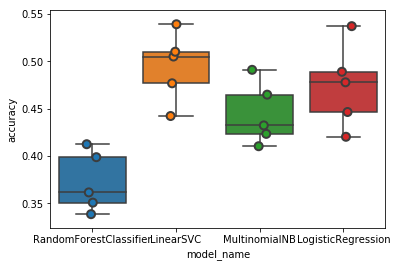

In [177]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [253]:
cv_df.groupby('model_name').accuracy.mean()



model_name
LinearSVC                 0.494638
LogisticRegression        0.474123
MultinomialNB             0.444368
RandomForestClassifier    0.372468
Name: accuracy, dtype: float64

In [179]:
from sklearn.model_selection import train_test_split

model = LinearSVC()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [185]:
label_list = df.label.unique()


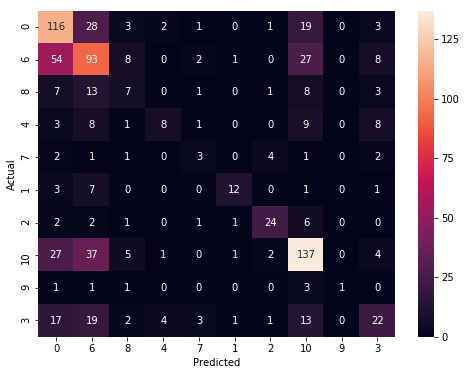

In [187]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=label_list, yticklabels=label_list)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [191]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['label'].unique()))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57       173
           6       0.44      0.48      0.46       193
           8       0.24      0.17      0.20        40
           4       0.53      0.21      0.30        38
           7       0.25      0.21      0.23        14
           1       0.75      0.50      0.60        24
           2       0.73      0.65      0.69        37
          10       0.61      0.64      0.63       214
           9       1.00      0.14      0.25         7
           3       0.43      0.27      0.33        82

    accuracy                           0.51       822
   macro avg       0.55      0.40      0.43       822
weighted avg       0.52      0.51      0.50       822



In [11]:
##failed attemp with using chi2 on imbalanced data

# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(df.cleantext).toarray()
# labels = df.label
# features.shape

# label_list = df[['label']].drop_duplicates().sort_values('label')


# from sklearn.feature_selection import chi2
# N = 2
# for i in sorted(label_list.values):
#   features_chi2 = chi2(features, labels == i)
#   indices = np.argsort(features_chi2[0])
#   feature_names = np.array(tfidf.get_feature_names())[indices]
#   unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

(2489, 1235)